In [1]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
import re
import string
import numpy as np
import warnings
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
df = pd.read_csv('/content/fake_news_data.csv')
df.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


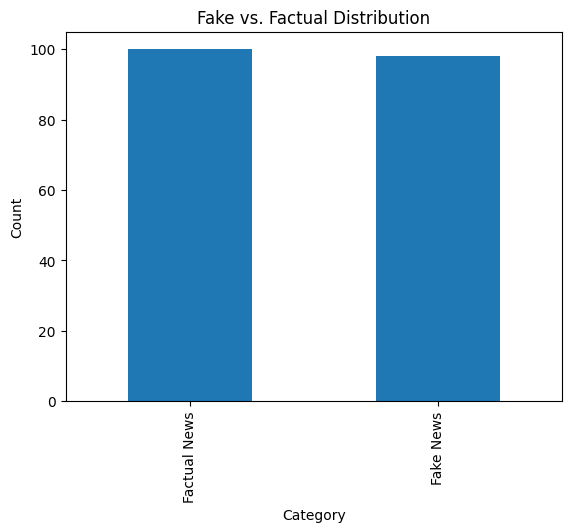

In [5]:
df['fake_or_factual'].value_counts().plot(kind='bar')
plt.title('Fake vs. Factual Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# POS Tagging

In [6]:
nlp = spacy.load('en_core_web_sm')

In [7]:
fake_news = df[df['fake_or_factual'] == 'Fake News']
fact_news = df[df['fake_or_factual'] == 'Factual News']

In [8]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(fact_news['text']))

In [9]:
def extract_token_tags(text):
    return [(token.text, token.ent_type_, token.pos_) for token in text]

In [10]:
# ipython-input-10-d110f2747d4b
fake_tagsdf = [] # Initialize as an empty list to store DataFrames
columns = ["token", "ner_tag", "pos_tag"]

# ipython-input-15-d110f2747d4b
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags, columns=columns)
    fake_tagsdf.append(tags) # Append each DataFrame to the list

# ipython-input-27-d110f2747d4b
fake_tagsdf = pd.concat(fake_tagsdf, ignore_index=True) # Concatenate the list of DataFrames

In [11]:
fact_tagsdf = [] # Initialize as an empty list to store DataFrames
columns = ["token", "ner_tag", "pos_tag"]

# ipython-input-15-d110f2747d4b
for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags, columns=columns)
    fact_tagsdf.append(tags) # Append each DataFrame to the list

# ipython-input-27-d110f2747d4b
fact_tagsdf = pd.concat(fact_tagsdf, ignore_index=True) # Concatenate the list of DataFrames

In [12]:
pos_count_fake = fake_tagsdf.groupby(["token", 'pos_tag']).size().reset_index(name='count').sort_values('count', ascending=False)
pos_count_fake

,token,pos_tag,count
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875
...,...,...,...
8016,yen,NOUN,1
3603,currencies,NOUN,1
3606,curriculum,NOUN,1
3607,cursing,VERB,1


In [13]:
pos_count_fact = fact_tagsdf.groupby(["token", 'pos_tag']).size().reset_index(name='count').sort_values('count', ascending=False)
pos_count_fact

,token,pos_tag,count
6169,the,DET,1903
15,",",PUNCT,1698
22,.,PUNCT,1381
4733,of,ADP,884
1905,a,DET,789
...,...,...,...
2061,allegedly,ADV,1
2064,alliances,NOUN,1
2073,alone,ADV,1
2075,along,ADV,1


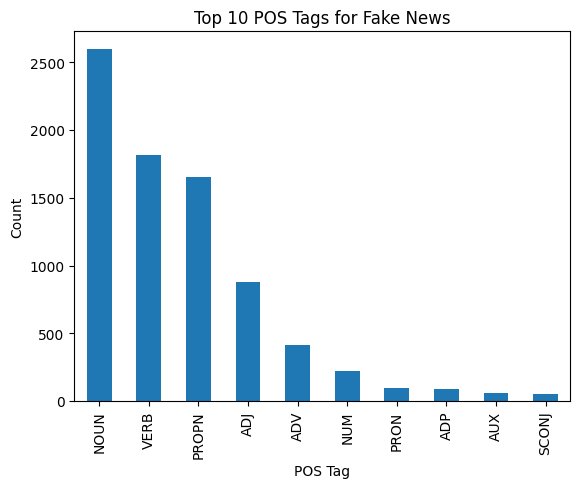

In [14]:
pos_count_fake.groupby('pos_tag')["token"].count().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 POS Tags for Fake News')
plt.xlabel('POS Tag')
plt.ylabel('Count')
plt.show()

Text(0.5, 0, 'POS Tag')

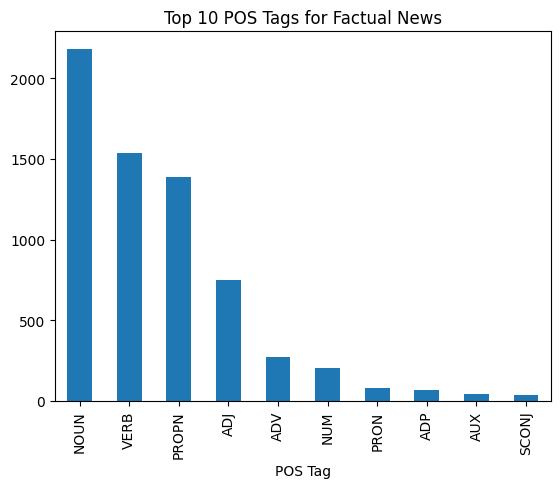

In [15]:
pos_count_fact.groupby('pos_tag')["token"].count().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 POS Tags for Factual News')
plt.xlabel('POS Tag')

In [16]:
pos_count_fake[pos_count_fake['pos_tag'] == 'NOUN'][:15]

,token,pos_tag,count
5969,people,NOUN,77
7959,women,NOUN,55
6204,president,NOUN,53
7511,time,NOUN,52
3134,campaign,NOUN,44
8011,year,NOUN,44
4577,government,NOUN,41
8013,years,NOUN,40
7344,t,NOUN,40
5208,law,NOUN,40


In [17]:
pos_count_fact[pos_count_fact['pos_tag'] == 'NOUN'][:15]

,token,pos_tag,count
3748,government,NOUN,71
6639,year,NOUN,64
5927,state,NOUN,58
2373,bill,NOUN,55
1982,administration,NOUN,51
3289,election,NOUN,48
5084,president,NOUN,47
4937,people,NOUN,45
4804,order,NOUN,45
4271,law,NOUN,42


# Named Entities

In [18]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ''].groupby(["token", 'ner_tag']).size().reset_index(name='count').sort_values('count', ascending=False)
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ''].groupby(["token", 'ner_tag']).size().reset_index(name='count').sort_values('count', ascending=False)

In [19]:
ner_palette = {
    'ORG':sns.color_palette("Set2").as_hex()[0],
    'GPE':sns.color_palette("Set2").as_hex()[1],
    'NORP':sns.color_palette("Set2").as_hex()[2],
    'PERSON':sns.color_palette("Set2").as_hex()[3],
    'DATE':sns.color_palette("Set2").as_hex()[4],
    'CARDINAL':sns.color_palette("Set2").as_hex()[5],
    'PERCENT':sns.color_palette("Set2").as_hex()[6],
}

Text(0.5, 1.0, 'Top 10 Named Entities for Fake News')

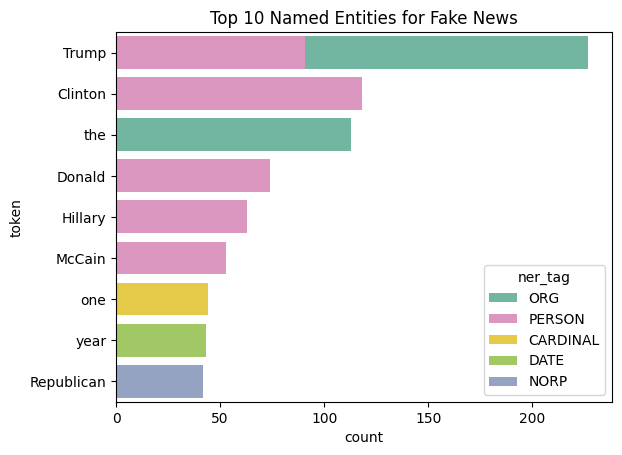

In [20]:
sns.barplot(
    x='count',
    y='token',
    hue='ner_tag',
    data=top_entities_fake[:10],
    palette=ner_palette,
    orient='h',
    dodge=False
).set_title('Top 10 Named Entities for Fake News')


Text(0.5, 1.0, 'Top 10 Named Entities for Factual News')

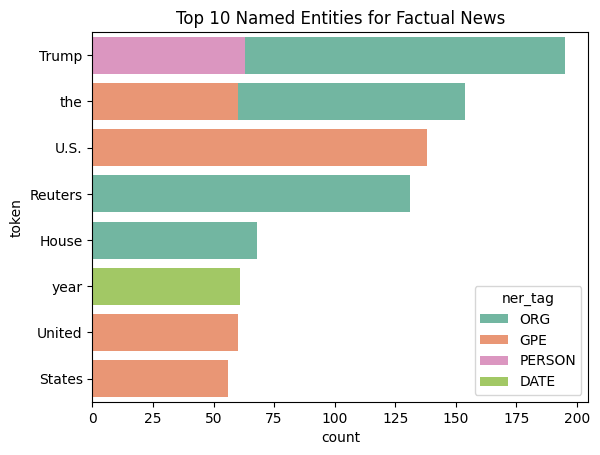

In [21]:
sns.barplot(
    x='count',
    y='token',
    hue='ner_tag',
    data=top_entities_fact[:10],
    palette=ner_palette,
    orient='h',
    dodge=False
).set_title('Top 10 Named Entities for Factual News')

# Text Pre-Processong

In [22]:
df['text_clean'] = df['text'].apply(lambda x: x.lower())

In [23]:
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'^[^-]*-\s', '', x))

In [24]:
df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r'([^\w\s])', '', x))

In [25]:
en_stopwords = stopwords.words('english')
df['text_clean'] = df['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in en_stopwords]))

In [26]:
df['text_clean'] = df['text_clean'].apply(lambda x: word_tokenize(x))

In [27]:
WordNetLemmatizer = WordNetLemmatizer()
df['text_clean'] = df['text_clean'].apply(lambda x: [WordNetLemmatizer.lemmatize(word) for word in x])

In [28]:
token_clean = sum(df['text_clean'], [])

In [29]:
unigrams = (pd.Series(nltk.ngrams(token_clean, 1)).value_counts())
bigrams = (pd.Series(nltk.ngrams(token_clean, 2)).value_counts())

In [30]:
unigrams.head(10)

,count
"(said,)",580
"(trump,)",580
"(u,)",277
"(state,)",275
"(president,)",259
"(would,)",226
"(one,)",160
"(clinton,)",141
"(year,)",139
"(republican,)",137


Text(0.5, 1.0, 'Top 10 Unigrams')

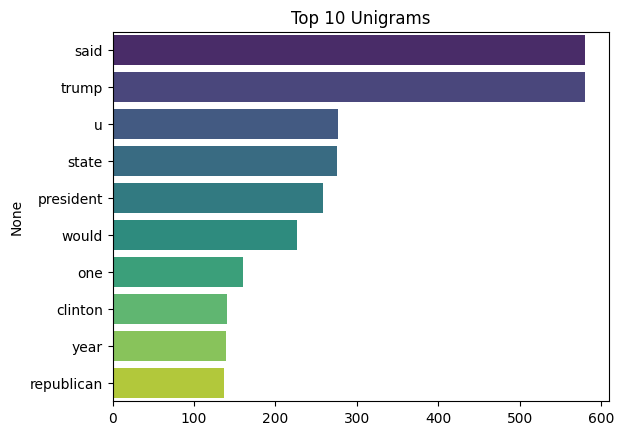

In [31]:
# Convert the MultiIndex to a string representation
unigrams.index = unigrams.index.map(lambda x: ' '.join(x))

sns.barplot(
    x=unigrams.values[:10],
    y=unigrams.index[:10],
    orient='h',
    palette='viridis'
).set_title('Top 10 Unigrams')

# Sentiment Analysis

In [32]:
vader = SentimentIntensityAnalyzer()

In [33]:
df["vader_score"] = df["text"].apply(lambda x: vader.polarity_scores(x)["compound"])

In [34]:
bins = [-1, -0.1, 0.1, 1]
labels = ["Negative", "Neutral", "Positive"]
df["vader_label"] = pd.cut(df["vader_score"], bins=bins, labels=labels)

In [35]:
df

,title,text,date,fake_or_factual,text_clean,vader_score,vader_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,Negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,Negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,Positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,Negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,Positive
...,...,...,...,...,...,...,...
193,AND SO IT BEGINS…INSPIRED BY GAY MARRIAGE RULI...,"Well, that didn t take long. Look for the firs...","Jul 2, 2015",Fake News,"[well, take, long, look, first, beastiality, m...",0.9001,Positive
194,‘Stand Your Ground’: FL Man Shoots At Teens P...,Florida s toxic and dangerous stand your grou...,"July 17, 2016",Fake News,"[florida, toxic, dangerous, stand, ground, gun...",-0.9946,Negative
195,The Los Angeles Times Endorses Hillary Clinto...,As Politico reports an almost neck-and-neck ra...,"May 30, 2016",Fake News,"[politico, report, almost, neckandneck, race, ...",0.9958,Positive
196,FBI chief sought more funds for Russia probe d...,WASHINGTON (Reuters) - Former FBI Director Jam...,"May 10, 2017",Factual News,"[former, fbi, director, james, comey, requeste...",-0.5719,Negative


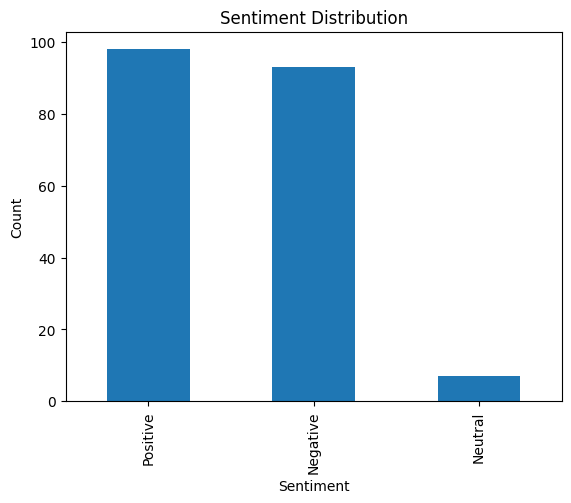

In [36]:
df['vader_label'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

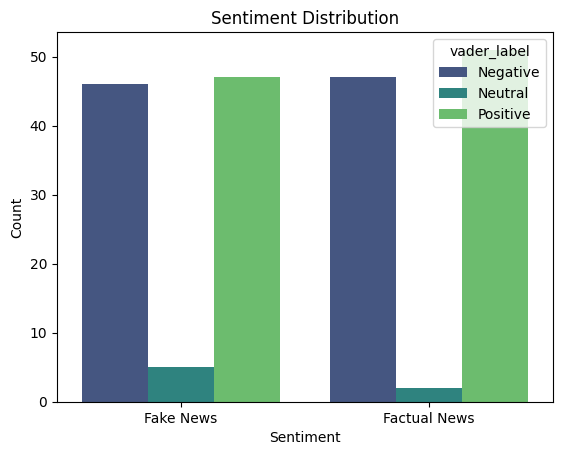

In [37]:
sns.countplot(x='fake_or_factual',
              data=df,
              hue="vader_label",
              palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Topic Modelling

In [38]:
fake_news_text = df[df['fake_or_factual'] == 'Fake News']["text_clean"].reset_index(drop=True)

In [39]:
dictionary = corpora.Dictionary(fake_news_text)
corpus = [dictionary.doc2bow(text) for text in fake_news_text]

In [40]:
coherence_values = []
model_list = []


for num_topics in range(2, 11):
    model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=num_topics)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

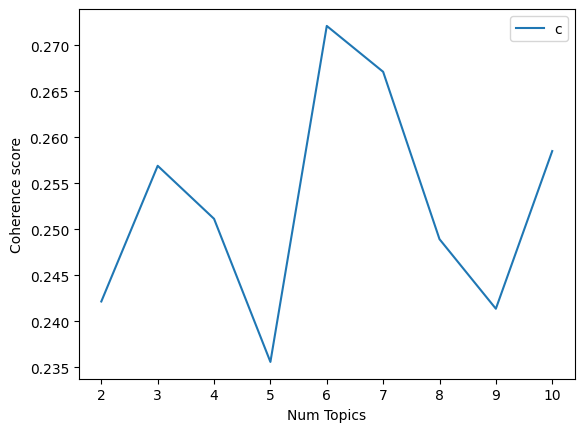

In [41]:
plt.plot(range(2, 11), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [42]:
num_topics = 7
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=dictionary,
                                   num_topics=num_topics)

In [43]:
lda_model.print_topics()

[(0,
  '0.005*"trump" + 0.005*"president" + 0.004*"state" + 0.004*"u" + 0.004*"people" + 0.004*"said" + 0.003*"one" + 0.003*"law" + 0.003*"clinton" + 0.003*"want"'),
 (1,
  '0.013*"trump" + 0.006*"said" + 0.005*"state" + 0.005*"clinton" + 0.004*"donald" + 0.004*"u" + 0.004*"would" + 0.003*"time" + 0.003*"one" + 0.003*"email"'),
 (2,
  '0.017*"trump" + 0.006*"said" + 0.005*"one" + 0.005*"time" + 0.004*"would" + 0.004*"people" + 0.004*"clinton" + 0.003*"republican" + 0.003*"donald" + 0.003*"president"'),
 (3,
  '0.005*"president" + 0.005*"trump" + 0.005*"state" + 0.004*"obama" + 0.004*"said" + 0.004*"year" + 0.003*"american" + 0.003*"u" + 0.003*"would" + 0.003*"clinton"'),
 (4,
  '0.011*"trump" + 0.006*"woman" + 0.005*"clinton" + 0.004*"said" + 0.004*"donald" + 0.004*"president" + 0.004*"u" + 0.003*"hillary" + 0.003*"republican" + 0.003*"people"'),
 (5,
  '0.007*"trump" + 0.005*"president" + 0.005*"u" + 0.005*"state" + 0.004*"said" + 0.004*"would" + 0.003*"one" + 0.003*"obama" + 0.003*"s

In [44]:
def tfidf_corpus(corpus):
    tfidf = TfidfModel(corpus, normalize=True)
    corpus_tfidf = tfidf[corpus]
    return corpus_tfidf

In [45]:
def get_coherence_score(corpus, dictionary, text, min_topics, max_topics):
    coherence_scores = []
    model_list = []
    for num_topics in range(min_topics, max_topics + 1):
        lda_model = LsiModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherencemodel.get_coherence())
    plt.plot(range(min_topics, max_topics + 1), coherence_scores)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')


In [46]:
corpus_tfidf = tfidf_corpus(corpus)

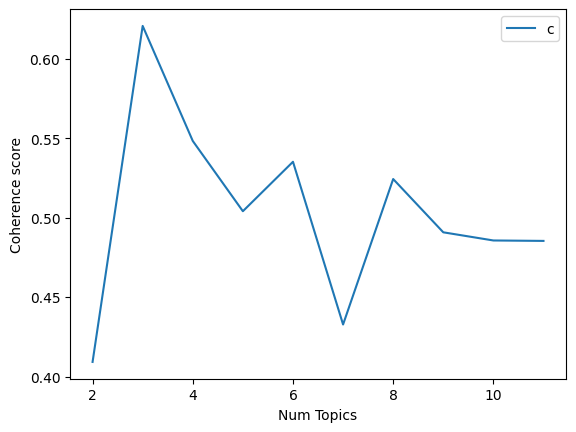

In [47]:
get_coherence_score(corpus_tfidf, dictionary, fake_news_text, 2, 11)

In [48]:
lsa_model = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=7)

In [49]:
lsa_model.print_topics()

[(0,
  '-0.190*"trump" + -0.136*"clinton" + -0.095*"hillary" + -0.094*"obama" + -0.089*"president" + -0.087*"woman" + -0.078*"republican" + -0.077*"party" + -0.077*"flynn" + -0.074*"candidate"'),
 (1,
  '-0.325*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"tune" + -0.142*"animal" + -0.134*"jay" + -0.132*"episode"'),
 (2,
  '-0.623*"flynn" + -0.182*"immunity" + -0.122*"nana" + -0.116*"mr" + -0.110*"30" + -0.108*"march" + -0.102*"russian" + -0.100*"source" + 0.095*"school" + -0.092*"adviser"'),
 (3,
  '0.217*"clinton" + -0.186*"school" + -0.176*"student" + 0.141*"hillary" + -0.121*"county" + -0.121*"flynn" + 0.110*"sander" + 0.098*"debate" + 0.097*"woman" + 0.091*"nominee"'),
 (4,
  '0.200*"email" + -0.194*"trump" + 0.168*"dnc" + -0.142*"flynn" + 0.126*"clinton" + -0.112*"cruz" + 0.111*"department" + 0.110*"rich" + 0.102*"wikileaks" + 0.099*"sander"'),
 (5,
  '-0.276*"student" + -0.160*"conference" + -0.160*"school" + -0.137*"trump"

# Training

In [50]:
X =[', '.join(map(str, l)) for l in df['text_clean']]
y = df['fake_or_factual']

In [51]:
countvec = CountVectorizer()
X = countvec.fit_transform(X)

In [52]:
bag_of_words = pd.DataFrame(X.toarray(), columns=countvec.get_feature_names_out())

In [53]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, y, test_size=0.3, random_state=42)

In [54]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [55]:
y_pred = lr.predict(X_test)

In [56]:
accuracy_score(y_test, y_pred)

0.8666666666666667

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

Factual News       0.88      0.88      0.88        32
   Fake News       0.86      0.86      0.86        28

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



In [58]:
svm = SGDClassifier()
svm.fit(X_train, y_train)

SGDClassifier()

In [59]:
y_pred = svm.predict(X_test)

In [60]:
accuracy_score(y_test, y_pred)

0.8333333333333334

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

Factual News       0.89      0.78      0.83        32
   Fake News       0.78      0.89      0.83        28

    accuracy                           0.83        60
   macro avg       0.84      0.84      0.83        60
weighted avg       0.84      0.83      0.83        60



# GridSearchCV

In [67]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# ... (Your existing code) ...

# Before the model training loop:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test) # Assuming you have a y_test for evaluation

In [68]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV


# Initialize models
lr = LogisticRegression(random_state=42, max_iter=1000)
sgd = SGDClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


# Updated parameter grids
param_grid_lr = {'C': [0.01, 0.1, 1], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
param_grid_sgd = {'loss': ['log_loss'], 'penalty': ['l2'], 'alpha': [0.0001, 0.001]}
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [10, 20]}
param_grid_gb = {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.2], 'max_depth': [3, 5]}
param_grid_xgb = {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.2], 'max_depth': [3, 5]}

models_with_grids = {
    'Logistic Regression': (lr, param_grid_lr),
    'SGD Classifier': (sgd, param_grid_sgd),
    'Random Forest': (rf, param_grid_rf),
    'Gradient Boosting': (gb, param_grid_gb),
    'XGBoost': (xgb, param_grid_xgb),
}

results = {}
for name, (model, param_grid) in models_with_grids.items():
    print(f"Tuning {name}...")
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='accuracy', cv=3, n_jobs=-1, n_iter=10, random_state=42)
    random_search.fit(X_train, y_train)
    print(f"Best Parameters for {name}:", random_search.best_params_)
    print(f"Best Training Score for {name}:", random_search.best_score_)

    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy for {name}: {accuracy}\n")
    print(f"Classification Report for {name}:\n{classification_report(y_test, y_pred)}\n")

    results[name] = {
        'Best Params': random_search.best_params_,
        'Train Accuracy': random_search.best_score_,
        'Test Accuracy': accuracy,
    }

summary = pd.DataFrame({
    'Model': results.keys(),
    'Train Accuracy': [results[m]['Train Accuracy'] for m in results],
    'Test Accuracy': [results[m]['Test Accuracy'] for m in results]
}).sort_values(by='Test Accuracy', ascending=False)

print(summary)

Tuning Logistic Regression...
Best Parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}
Best Training Score for Logistic Regression: 0.9202898550724639
Test Accuracy for Logistic Regression: 0.8833333333333333

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        32
           1       0.92      0.82      0.87        28

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60


Tuning SGD Classifier...
Best Parameters for SGD Classifier: {'penalty': 'l2', 'loss': 'log_loss', 'alpha': 0.001}
Best Training Score for SGD Classifier: 0.9057971014492754
Test Accuracy for SGD Classifier: 0.8

Classification Report for SGD Classifier:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1   